## Police Stops in San Diego 2014-2017 Fairness Evalutation  
[Dataset Source](https://openpolicing.stanford.edu/data/)

##### David Aminifard  
##### A15451805  
##### Aaron Mcmillan Fraenkel  

## Introduction & Context:  

> America's history of disproportionate treatment of people based on their backgrounds has long been subject to scrutinty, and yet has often been perpetuated by bad policy and bad policing. The article, "Targeting young men of color for search and arrest during traffic stops: evidence from North Carolina, 2002–2013", written by, Frank R. Baumgartner, Derek A. Epp, Kelsey Shoub & Bayard Love, showed evidence of strong racial bias in policing. This bias is often directed towards young men of color and isolates minority communities, and much of this has been worsening in the wake of the war on drugs in North Carolina(111). Their analysis of North Carolina police stop data revealed that "North Carolina’s Black men, who are searched at much higher rates than their White counterparts, but are less likely to be found with contraband in discretionary police searches"(123). This indicates that there is racial bias in how North Carolina's motorways are policed and how people are searched.

> Seeing the situation in North Carolina, this begs the question: Does racial bias in San Diego's motorways unfairly affect the outcomes of police stops? 

> The article, "Traffic Enforcement Through the Lens of Race: A Sequential Analysis of  Post-Stop Outcomes in San Diego, California", written by, Joshua Chanin, Megan Welsh, and Dana Nurge, reveals similar discrimination in police stops in San Diego. Its results revealed that, "Black drivers were searched at a rate of 8.97%, some more than 3 times that of Whites (2.65%)"(568), despite that " 7.11% of searches  involving Black drivers led to a “hit” compared with the 10.54% hit rate for Whites"(568). The article defines hit as when contraband is found during a search (565). In addition, the article uses propensity score matching to match Black and White drivers based on variables thay may influence whether they're issued a citation or not. The results indicated that race is "the only factor that may explain the observed differences in post-stop out-comes"(567), which means that there is strong evidence that racial bias influences how San Diego's mortorways are policed.

> Given this context, this report will analyse police stop data made available by The Stanford Open Policing Project. In particular, we will look at San Diego's police stop data, and identify and analyze potential inequity in light of the evidence there is for North Carolina's and San Diego's bad policing using parity measures and A/B testing. 

> This report will consider fairness in terms of Rawlsian Fair Equality of Opportunity because it asserts that people shouldn't face obstacles related to their circumstances, and our analysis of San Diego's police stop data may provide evidence of disparate treatement based on a person's background, i.e. circumstances, which would violate this notion of fairness. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
pd.options.mode.chained_assignment = None
import dask
import time
from dask import distributed
from dask import delayed
from IPython.display import display, HTML

In [2]:
client = distributed.Client(n_workers=8)
#plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 60 # 200 e.g. is really fine, but slower
df = pd.read_csv('ca_san_diego_2020_04_01.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

## EDA & Data Description

> The visualizations below show that Hispanics are subject to the most total searches. However, they do not take into account the amount of people per each group there are in the population of San Diego. 

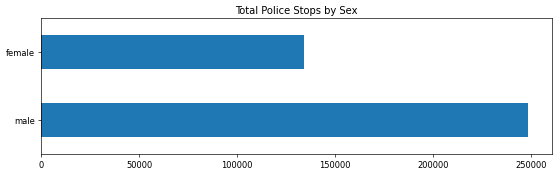

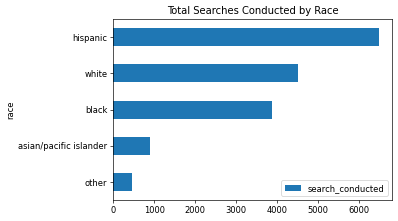

In [4]:
#df['subject_race'].value_counts().plot(kind='barh', title="Total Police stops by Race", figsize=(11,3))
#plt.show()
df['subject_sex'].value_counts().plot(kind='barh', title="Total Police Stops by Sex", figsize=(11,3))
plt.show()
race_search = df[['subject_race', 'search_conducted']]
race_search['search_conducted'] = race_search['search_conducted'].apply(lambda x: 1 if x==True else 0)
race_search.groupby('subject_race').sum().sort_values(by="search_conducted").plot(kind='barh', xlabel="race", title="Total Searches Conducted by Race")
plt.show()

> Since we do not know the proportion of people in each group with respect to the population of San Diego, we will investigate further in the rates of searches with respect to the amount of people in each group in the dataset. The visualizations below reveal that Blacks and Hispanics are searched at a much higher rate than Whites and Asians/Pacific Islanders.

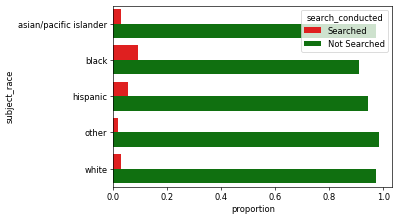

In [5]:
race_search = df[['subject_race', 'search_conducted']]
race_search['search_conducted'] = race_search['search_conducted'].apply(lambda x: 1 if x==True else 0)
race_search_df = (race_search.groupby(['subject_race']))['search_conducted'].value_counts(normalize=True).rename('proportion').reset_index()
race_search_df['search_conducted'] = race_search_df['search_conducted'].apply(lambda x: 'Searched' if x==1 else 'Not Searched')
sns.barplot(x='proportion', y='subject_race', hue='search_conducted', data=race_search_df, hue_order=['Searched', 'Not Searched'], palette=['r','g'], orient="h")
plt.show()

> Seeing that Blacks and Hispanics have a higher rate of being searched, we'd assume that there would be a higher rate of contraband being found. However, the visualizations reveal below that Blacks and Hispanics have a lower rate of contraband being found than Whites and Asians/Pacific Islanders.

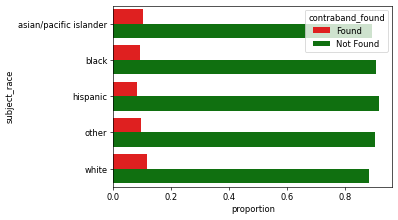

proportion          
contraband_found            Found Not Found
subject_race                               
asian/pacific islander   0.104396  0.895604
black                    0.093209  0.906791
hispanic                 0.081218  0.918782
other                    0.095344  0.904656
white                    0.114856  0.885144

In [6]:
race_contraband = df[['subject_race', 'contraband_found']].dropna()
race_contraband['contraband_found'] = race_contraband['contraband_found'].apply(lambda x: 1 if x==True else 0)
race_contraband_df = (race_contraband.groupby(['subject_race']))['contraband_found'].value_counts(normalize=True).rename('proportion').reset_index()
race_contraband_df['contraband_found'] = race_contraband_df['contraband_found'].apply(lambda x: 'Found' if x==1 else 'Not Found')
sns.barplot(x='proportion', y='subject_race', hue='contraband_found', data=race_contraband_df, hue_order=['Found', 'Not Found'], palette=['r','g'], orient="h")
plt.show()
pd.pivot_table(data=race_contraband_df, 
               values = ["proportion"], 
               columns=["contraband_found"], 
               index=["subject_race"]
              )

## We will analyze this in terms of Demographic parity:

> Demographic parity is used since it fits in with Rawlsian FEO and we want to focus on whether there is a disproportionate amount of True positives in police searches, i.e. disparate impact. The harms in this case are false positives, because it's unfair for people to be searched when they are not carrying any contraband. Demographic parity is satisfied when P(C=1|A=a)~P(C=1|A=b) for all groups a,b.

> False Postitive: Searched, No contraband found<br>
> True Positive: Searched, contraband found<br>
> False Negative: Not searched, no contraband found (Cannot calculate)<br>
> True Negative: Not searched, contraband found (Cannot calculate)

> Lets assume that this police stop dyanmic is similar to that of a prediction model. A police officer acts as the test deciding who's positive or negative (searched or not searched). Whether a person has contraband or not reveals whether the test yielded a true positive or false positive. 

> Initially, it's clear, just from looking at the data, that  P(C=search_conducted | A=Black) does not equal  P(C=search_conducted | A=White) since Blacks are searched more often than Whites: Proportion of Whites searched: 0.027801 versus proportion of Blacks searched: 0.090692.

> While this does not satisfy Demographic parity, we'd at least assume that the amount of contraband being found from Blacks being searched would be greater than the amount of contraband being found from Whites being searched. However, this not the case, and this falls in line with what was covered in the aformentioned article regarding Post-Stop Outcomes in San Diego.

> P(C=contraband_found | A=Black) is less than P(C=contraband_found | A=White), (0.093209 < 0.114856), which indicates that there is a severe inequity that may be based on race. This shows that Blacks have a lower proportion of true positives compared to Whites. The dataset does not satisfy Demographic parity.

> This means that this hypothetical prediction model seems to fail more often for Blacks than Whites. Not only are Blacks searched more often then Whites (as shown earlier), but the searches have a lower likelihood of finding contraband. As a result, our hypothetical prediction model, the police, does not satisfy Demographic parity in terms of the searches.

> Unfortunately, we cannot calculate true/false negatives because we don't know if someone had contraband if they were not searched, which limits our ability to use parity measures to guage fairness. However, we still can further validate our prior findings through confirming whether they're statistically significant. To do this, we will use A/B testing, which will involve resampling/shuffling the data ten thousand times and quantifying if the samples of Blacks and Whites come from the same underlying distribution in terms of their true positive proportions.

## A/B Testing

>  Null Hypothesis: Blacks and Whites have a similar proportion of true positives

> Alternative Hypothesis: Blacks and Whites do not have a similar proportion of true positives

> The null hypothesis suggests that our prior findings are simply due to chance and are within reasonable bounds, whereas the alternative hypothesis suggests that our prior findings are significant.

> Our test statistic will be the difference in true positive proportions between Whites and Blacks. We will use permutation testing to simulate our test statistic ten thousand times to decide whether our findings were significant or not. We will set our significance level at .01, so if our resulting p value is less than .01 then our prior findings were significant.

In [7]:
race_contraband = df[['subject_race', 'contraband_found']].loc[(df['subject_race']=='black')|
                                                               (df['subject_race']=='white')].dropna()
race_contraband['contraband_found'] = race_contraband['contraband_found'].apply(lambda x: 1 if x==True else 0)
race_contraband.reset_index(drop=True, inplace=True)
race_contraband_df = (race_contraband.groupby(['subject_race']))['contraband_found'].value_counts(normalize=True).rename('proportion').reset_index()
race_contraband_df['contraband_found'] = race_contraband_df['contraband_found'].apply(lambda x: 'Found' if x==1 else 'Not Found')
race_contraband_df = pd.pivot_table(data=race_contraband_df, 
                                    values = ["proportion"], 
                                    columns=["contraband_found"], 
                                    index=["subject_race"]
                                   )

In [8]:
def calc_dif_prop(curr_df):
    curr_df = (curr_df.groupby(['subject_race']))['contraband_found'].value_counts(normalize=True).rename('proportion').reset_index()
    curr_df['contraband_found'] = curr_df['contraband_found'].apply(lambda x: 'Found' if x==1 else 'Not Found')
    curr_df = pd.pivot_table(data=curr_df, 
                            values = ["proportion"], 
                            columns=["contraband_found"], 
                            index=["subject_race"]
                           )
    return curr_df[('proportion', 'Found')][0] -  curr_df[('proportion', 'Found')][1]

In [9]:
def simulate_shuffle(curr_df):
    race_shuffle = curr_df.sample(n=curr_df.shape[0], replace=False).reset_index(drop=True)['subject_race']
    test_curr_df = curr_df.copy()
    test_curr_df['subject_race'] = race_shuffle
    
    return calc_dif_prop(test_curr_df)

In [10]:
obs_dif = calc_dif_prop(race_contraband)
print(f"Observed difference: {obs_dif}")

Observed difference: -0.021646477432311823


In [11]:
differences = []
reps = 10000

for i in range(reps):
    differences.append(dask.delayed(simulate_shuffle)(race_contraband))
differences = dask.compute(differences)[0]

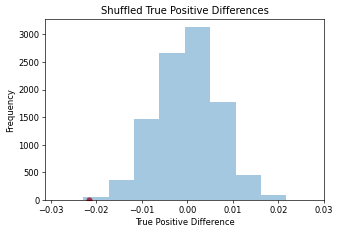

In [14]:
plt.hist(differences, alpha=.4, label="test")
plot = plt.scatter(obs_dif, 0, color='red', s=40)
plt.title('Shuffled True Positive Differences')
plt.xlabel('True Positive Difference')
plt.ylabel('Frequency')
plt.show()

In [15]:
p_val = np.count_nonzero(differences <= obs_dif)/reps
print(f"P value: {p_val}")

P value: 0.0007


## Results & Conclusion

> Since our p value is less than .01, we can reject the null hypothesis in favor of the alternative hypothesis and conclude that the disproportionate amount of true positives (in terms of being searched and finding contraband) between Blacks and Whites is significant and not due to chance. 

> To put it briefly, we investigated police stops in San Diego to uncover whether searches are done fairly among different groups. We used Demographic parity to show whether searches are proportional to the contraband found among different groups of people, and our results indicated that Blacks experience a lower true positive proportion than Whites, which means that they're more often wrongly searched than Whites. In regards to our question, we have found strong evidence that racial bias in San Diego's motorways unfairly affect the outcomes of police stops. However, this is not definitive proof because the methods used are limited and only indicate a correlation. There's a large possibility of omitted variable bias, for example, because we haven't considered many of the possible factors that influence whether someone is searched. 

## Works Cited
> Frank R. Baumgartner, Derek A. Epp, Kelsey Shoub & Bayard Love(2017) Targeting young men of color for search and arrest during traffic stops: evidencefrom North Carolina, 2002–2013, Politics, Groups, and Identities, 5:1, 107-131, DOI:10.1080/21565503.2016.1160413

> Chanin J, Welsh M, Nurge D. Traffic Enforcement Through the Lens of Race: A Sequential Analysis of Post-Stop Outcomes in San Diego, California. Criminal Justice Policy Review. 2018;29(6-7):561-583. doi:10.1177/0887403417740188